## Generate fake data...

In [22]:
max_pct_bias = 35
introduce_bias_n_days_before = 28
bias_power = 2

wellness_max_pct_bias = 200
wellness_bias_power = 1

# Whether to apply the inactivity reduction
apply_inactivity_reduction = True
# Window for which inactivity is checked
check_n_days_for_inactivity = 7
# Max reduction of training duration
max_inactivity_reduction = 0.5
# Minimum number of practices to be considered as active
min_n_practices_as_active = 3                

# Types of bias
# - Seiler's blackhole
# - No slow build-up
# - Too high volume
# - No recovery

In [23]:
# Import libraries
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [24]:
# Initializes a dataframe with injuries
def generate_fake_injury_data(n_individuals = 12, time_span_years = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3):
    fake = Faker()
    end_date = datetime.today()
    start_date = end_date - timedelta(days=int(time_span_years * 365))
    date_range = pd.date_range(start=start_date, end=end_date)
    
    data = []
    
    for user_id in range(1, n_individuals + 1):
        user_name = fake.name()
        currently_injured = False
        injury_end_date = None
        injury_idx = None
        
        for date in date_range:
            injury_onset = False
            
            if not currently_injured and np.random.rand() < injury_onset_incidence:
                injury_onset = True
                duration = max(1, int(np.random.normal(injury_duration_mean, injury_duration_std)))
                injury_end_date = date + timedelta(days=duration)
                currently_injured = True
                injury_idx = f'{user_id}_{date.strftime("%d_%m_%Y")}'
            
            if currently_injured and date >= injury_end_date:
                currently_injured = False
                injury_end_date = None
                injury_idx = None
            
            data.append([user_id, user_name, date, injury_onset, currently_injured, injury_idx])
    
    df = pd.DataFrame(data, columns=["user_id", "user_name", "date", "injury_onset", "currently_injured", 'injury_idx'])

    return df

# Example usage:
injury_data = generate_fake_injury_data(n_individuals = 12, time_span_years = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3)

In [25]:
# Construct a useful feature that tracks how many days until the next injury
def add_days_until_next_injury(df_user_id, introduce_bias_n_days_before, upcoming_injury_col_full, upcoming_injury_col_half, upcoming_injury_col_quarter):
     df_user_id['days_until_next_injury'] = np.nan
     for injury_idx in df_user_id['injury_idx'].unique():
          if str(injury_idx) == 'nan' or injury_idx is None:
               continue
          cur_injury = df_user_id.loc[df_user_id['injury_idx'] == injury_idx,:]
          cur_injury_date = cur_injury['date'].iloc[0]
          prior_to_injury_bool = (df_user_id['date'] <= cur_injury_date) & (df_user_id['days_until_next_injury'].isnull())
          delta_time = cur_injury_date - df_user_id['date']
          df_user_id.loc[prior_to_injury_bool, 'days_until_next_injury'] = delta_time.loc[prior_to_injury_bool].dt.days

     df_user_id[upcoming_injury_col_full] = df_user_id['days_until_next_injury'] <= introduce_bias_n_days_before
     df_user_id[upcoming_injury_col_half] = df_user_id['days_until_next_injury'] <= introduce_bias_n_days_before / 2
     df_user_id[upcoming_injury_col_quarter] = df_user_id['days_until_next_injury'] <= introduce_bias_n_days_before / 4
     return df_user_id

# Example usage:
upcoming_injury_col_full = f'upcoming_injury_within_{introduce_bias_n_days_before:02d}_days'
upcoming_injury_col_half = f'upcoming_injury_within_{int(introduce_bias_n_days_before/2):02d}_days'
upcoming_injury_col_quarter = f'upcoming_injury_within_{int(introduce_bias_n_days_before/4):02d}_days'
injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury, introduce_bias_n_days_before = introduce_bias_n_days_before, upcoming_injury_col_full = upcoming_injury_col_full, upcoming_injury_col_half = upcoming_injury_col_half, upcoming_injury_col_quarter = upcoming_injury_col_quarter).reset_index(drop=True)

C:\Users\rmeer\AppData\Local\Temp\ipykernel_24828\4083910010.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury, introduce_bias_n_days_before = introduce_bias_n_days_before, upcoming_injury_col_full = upcoming_injury_col_full, upcoming_injury_col_half = upcoming_injury_col_half, upcoming_injury_col_quarter = upcoming_injury_col_quarter).reset_index(drop=True)


In [26]:
# Add training load data (with or without bias)
# Define RPE tables with percentage distribution for each RPE value
rpe_tables = {
     'polarized': {
            1: 0.10, 2: 0.40, 3: 0.30, 4: 0.05, 5: 0.05, 6: 0.03, 7: 0.03, 8: 0.02, 9: 0.01, 10: 0.01
        },
     'pyramidal': {
            1: 0.10, 2: 0.20, 3: 0.20, 4: 0.15, 5: 0.15, 6: 0.10, 7: 0.05, 8: 0.03, 9: 0.01, 10: 0.01
        }
        }
# Define how often there is a training per week
training_per_week = {
    0: 0.00, 1: 0.02, 2: 0.08, 3: 0.20, 4: 0.34, 5: 0.29, 6: 0.06, 7: 0.01
}
##########
def normalize_dict_values(input_dict):
    # Calculate the sum of all values
    total_sum = sum(input_dict.values())
    
    # Normalize each value by dividing by the total sum
    normalized_dict = {key: value / total_sum for key, value in input_dict.items()}
    
    return normalized_dict
##########
def generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='polarized', introduce_bias_n_days_before = None, max_pct_bias = None, bias_power = 1, apply_inactivity_reduction = True, check_n_days_for_inactivity = 7, min_n_practices_as_active = 3, max_inactivity_reduction = 0.5):
    """
    Generate training load data based on existing injury data.
    The training load will be assigned only on days when the user is not injured.
    
    Parameters:
    - injury_data: DataFrame generated by `generate_fake_injury_data`
    - rpe_table: Choose 'polarized' or 'pyramidal' RPE table (default is 'polarized')
    
    Returns:
    - DataFrame with training load data.
    """
    
    # Select RPE table based on user input
    if rpe_table_type == 'polarized':
        pass
    elif rpe_table_type == 'pyramidal':
        pass
    elif rpe_table_type == 'randomly_assigned_per_user_id':
        pass
    else:
        raise ValueError("Invalid rpe_table_type. Choose 'randomly_assigned_per_user_id', 'polarized', or 'pyramidal'.")
    
    df = injury_data.copy()
    df['rpe'] = np.nan
    df['duration_minutes'] = np.nan
    df['training_distribution'] = ''

    # Loop over each user in the injury data
    for user_id in df['user_id'].unique():
        user_injury_data = df[df['user_id'] == user_id]

        cur_rpe_table_type = rpe_table_type
        if rpe_table_type == 'randomly_assigned_per_user_id':
            cur_rpe_table_type = np.random.choice(list(rpe_tables.keys()))            

        rpe_table = rpe_tables[cur_rpe_table_type]

        df.loc[user_injury_data.index, 'training_distribution'] = cur_rpe_table_type

        # For each row in the injury data (one row per day)
        cur_week = -1
        for idx, row in user_injury_data.iterrows():

            if cur_week != row['date'].week:
                # A new week
                cur_week = row['date'].week
                # Determine which weekdays will be practice days
                n_training_days = np.random.choice(list(training_per_week.keys()), p=list(training_per_week.values()))
                training_days = random.sample(range(8), n_training_days)

            if row['currently_injured']:
                continue  # Skip days when the user is injured
            if not row['date'].weekday() in training_days:
                continue # Skip day as not part of random subset of training days
            
            # Generate training load on days when the user is not injured
            rpe = np.random.choice(list(rpe_table.keys()), p=list(rpe_table.values()))

            soon_to_be_injured_bias = 1
            if not introduce_bias_n_days_before is None:
                if row['days_until_next_injury'] <= introduce_bias_n_days_before:

                    y = np.linspace(1, max_pct_bias/100+1, introduce_bias_n_days_before) ** bias_power
                    y1 = y + (1-min(y))
                    y2 = (y1-1) / (y1[-1]-1) * max_pct_bias/100+1  # Scale so the last value equals 2
                    nth_day_idx = int(introduce_bias_n_days_before-row['days_until_next_injury'])

                    soon_to_be_injured_bias = y2[nth_day_idx]

                    # Increase probability of RPE 5, 6?
                    adjusted_probs = {}
                    for key in rpe_table.keys():
                        adjustment = 1
                        if key == 5 or key == 6: # Increase RPE 5 and 6, Seilers black hole..
                            adjustment = soon_to_be_injured_bias
                        adjusted_probs[key] = adjustment*rpe_table[key]
                    adjusted_probs = normalize_dict_values(adjusted_probs)
                    rpe = np.random.choice(list(adjusted_probs.keys()), p=list(adjusted_probs.values()))

            # When there were few practices, there is an inactivity_reduction             
            inactivity_reduction = 1
            if apply_inactivity_reduction:
                n_practices_past_n_days = df.loc[(df['user_id'] == user_id)&(df['date'] > (row['date']  - pd.Timedelta(days=check_n_days_for_inactivity)))&(df['date'] < row['date']), 'duration_minutes'].notnull().sum()
                if n_practices_past_n_days < min_n_practices_as_active:
                    inactivity_reduction = 1 - ((min_n_practices_as_active + 1)-n_practices_past_n_days)* (max_inactivity_reduction / (min_n_practices_as_active + 1))

            # Determine training duration based on RPE
            if rpe <= 5:
                duration = np.random.randint(75*inactivity_reduction, 121*inactivity_reduction)  # 75-120 minutes for RPE 1-5
            elif rpe <= 8:
                duration = np.random.randint(45*inactivity_reduction, 91*inactivity_reduction)  # 45-90 minutes for RPE 6-8
            else:
                duration = np.random.randint(30*inactivity_reduction, 61*inactivity_reduction)  # 30-60 minutes for RPE 9-10
            
            biased_duration = int(duration * soon_to_be_injured_bias)
            df.loc[idx, 'rpe'] = rpe
            df.loc[idx, 'duration_minutes'] = biased_duration

            continue # End of for loop to iterate over current user_id
        continue # End of for loop to iterate over the different user_ids

    return df

# Example usage:
training_load_data = generate_fake_training_load_data_from_injury(injury_data, rpe_table_type='randomly_assigned_per_user_id')
biased_training_load_data = generate_fake_training_load_data_from_injury(injury_data, 
    rpe_table_type='randomly_assigned_per_user_id', 
    introduce_bias_n_days_before = introduce_bias_n_days_before, 
    max_pct_bias = max_pct_bias, bias_power = bias_power, 
    apply_inactivity_reduction = apply_inactivity_reduction,
    check_n_days_for_inactivity = check_n_days_for_inactivity,
    max_inactivity_reduction = max_inactivity_reduction,
    min_n_practices_as_active = min_n_practices_as_active)

In [27]:
# Add wellness data (with or without bias)
# Define wellness scores with percentage distribution for each item
wellness_tables = {
    'Energy Score': {
        1: 0.00459, 2: 0.00917, 3: 0.01835, 4: 0.05505, 5: 0.13761, 6: 0.27523, 
        7: 0.34404, 8: 0.13303, 9: 0.01835, 10: 0.00458
    },
    'Mood Score': {
        1: 0.00398, 2: 0.00797, 3: 0.01195, 4: 0.02390, 5: 0.07171, 6: 0.15936, 
        7: 0.39841, 8: 0.23904, 9: 0.05976, 10: 0.02392
    },
    'Recovery Score': {
        1: 0.00377, 2: 0.00755, 3: 0.01509, 4: 0.06038, 5: 0.13208, 6: 0.26415, 
        7: 0.30189, 8: 0.15094, 9: 0.05283, 10: 0.01132
    },
    'Motivation Score': {
        1: 0.01064, 2: 0.00709, 3: 0.01064, 4: 0.02128, 5: 0.06383, 6: 0.14184, 
        7: 0.35461, 8: 0.28369, 9: 0.07092, 10: 0.03546
    },
    'Confidence Score': {
        1: 0.00057, 2: 0.00229, 3: 0.00458, 4: 0.01145, 5: 0.05727, 6: 0.22910, 
        7: 0.45819, 8: 0.21764, 9: 0.01031, 10: 0.00860
    },
    'Sleep Quality Score': {
        1: 0.00426, 2: 0.00851, 3: 0.01702, 4: 0.03404, 5: 0.10213, 6: 0.21277, 
        7: 0.34043, 8: 0.17021, 9: 0.10213, 10: 0.00850
    }
}

def generate_fake_wellness_data_from_injury(injury_data, introduce_bias_n_days_before = None, max_pct_bias = None, bias_power = 1):
    """
    Generate wellness data based on existing injury data.
    The wellness will be assigned only on days when the user is not injured.
    
    Parameters:
    - injury_data: DataFrame generated by `generate_fake_injury_data`
    - wellness_tables: Choose 'polarized' or 'pyramidal' RPE table (default is 'polarized')
    
    Returns:
    - DataFrame with training load data.
    """
  
    df = injury_data.copy()
    df[list(wellness_tables.keys())] = np.nan

    # Loop over each user in the injury data
    for user_id in df['user_id'].unique():
        user_injury_data = df[df['user_id'] == user_id]

        # For each row in the injury data (one row per day)
        cur_week = -1
        for idx, row in user_injury_data.iterrows():

            if cur_week != row['date'].week:
                # A new week
                cur_week = row['date'].week
                # Determine which weekdays will be practice days
                n_training_days = np.random.choice(list(training_per_week.keys()), p=list(training_per_week.values()))
                training_days = random.sample(range(8), n_training_days)

            if row['currently_injured']:
                continue  # Skip days when the user is injured
            if not row['date'].weekday() in training_days:
                continue # Skip day as not part of random subset of training days
            
            soon_to_be_injured_bias = 1
            if not introduce_bias_n_days_before is None:
                if row['days_until_next_injury'] <= introduce_bias_n_days_before:

                    y = np.linspace(1, max_pct_bias/100+1, introduce_bias_n_days_before) ** bias_power
                    y1 = y + (1-min(y))
                    y2 = (y1-1) / (y1[-1]-1) * max_pct_bias/100+1  # Scale so the last value equals 2
                    nth_day_idx = int(introduce_bias_n_days_before-row['days_until_next_injury'])

                    soon_to_be_injured_bias = y2[nth_day_idx]

            for item_key in wellness_tables.keys():                
                item_table = wellness_tables[item_key]                

                # Increase probability of scores below 5
                adjusted_probs = {}
                for key in item_table.keys():
                    adjustment = 1
                    if key <= 5: # Increase RPE 5 and 6, Seilers black hole..
                        adjustment = soon_to_be_injured_bias
                    adjusted_probs[key] = adjustment*item_table[key]
                adjusted_probs = normalize_dict_values(adjusted_probs)
                item_val = np.random.choice(list(adjusted_probs.keys()), p=list(adjusted_probs.values()))
                df.loc[idx, item_key] = item_val
                
            continue # End of for loop to iterate over current user_id
        continue # End of for loop to iterate over the different user_ids

    return df

# Example usage:
training_load_en_wellness_data = generate_fake_wellness_data_from_injury(training_load_data)
biased_training_load_en_wellness_data = generate_fake_wellness_data_from_injury(biased_training_load_data, introduce_bias_n_days_before = introduce_bias_n_days_before, max_pct_bias = wellness_max_pct_bias, bias_power = wellness_bias_power)

## Feature Construction

In [28]:
# Construct some useful (and typical) features
def compute_sRPE(df, rpe_col = 'rpe', duration_col = 'duration_minutes', srpe_col = 'session_rpe'):
     # sRPE
     df[srpe_col] = df[rpe_col] * df[duration_col]
     return df
###########
# Wellness Average
def compute_wellness_avg(df, existing_wellness_cols):     
     df.loc[:, 'Wellness Average'] = df.loc[:, existing_wellness_cols].mean(axis = 1)
     return df
###########
def compute_load_sum(df, load_col, n_days_prev, date_col = 'date', user_id_col = 'user_id'):
     """
     Sums the values in the last `n_days_prev` previous days of column `load_col` for each `user_id_col`.

     Parameters:
     df (pd.DataFrame): The input dataframe.
     user_id_col (str): The column name for user ID.
     date_col (str): The column name for date.
     load_col (str): The column name for load values.
     n_days_prev (int): The number of previous days to sum.

     Returns:
     pd.DataFrame: DataFrame with summed values for each user_id and date.
     """
     sum_col = '%s_SUM_%.2d_days' %(load_col, n_days_prev)	
     std0_col = '%s_STD0_%.2d_days' %(load_col, n_days_prev)	     
     df = df.sort_values(by=[user_id_col, date_col])  # Sort by user and date

     for user_id, group in df[[date_col, user_id_col, load_col]].groupby(user_id_col):
          # Assumes complete data: an entry for every day an athlete is available
          group['orig_index'] = group.index
          group = group.set_index(date_col).sort_index()       
          
          # Compute rolling sum and standard deviation
          group[sum_col] = group[load_col].rolling(f'{n_days_prev}D', closed='right').sum()
          group[std0_col] = group[load_col].fillna(0).rolling(f'{n_days_prev}D', closed='right').std(ddof=0)

          # Set incomplete series to np.nan          
          since_start = group.index - group.index.min()
          group.loc[since_start.days < (n_days_prev-1), sum_col] = np.nan
          group.loc[since_start.days < (n_days_prev-1), std0_col] = np.nan

          group[user_id_col] = user_id  # Reintroduce user_id column
          group.reset_index().rename(columns={'index': date_col})
          group = group.set_index('orig_index')
          
          df.loc[group.index, group.columns] = group
     return df, sum_col, std0_col

###########
def compute_acwr_mon_str(df, n_days_prev_acute = 7, n_days_prev_chronic = 28, load_col = 'session_rpe'):
     # ACWR, Strain, Monotony
     acr_col = '%s_AC%.2d_%.2d_days' %(load_col, n_days_prev_acute, n_days_prev_chronic)
     monotony_col = '%s_MON_%.2d_days' %(load_col,  n_days_prev_chronic)	
     strain_col = '%s_STR_%.2d_days' %(load_col, n_days_prev_chronic)	

     df, acute_sum_col, acute_std0_col = compute_load_sum(df, load_col, n_days_prev_acute)
     df, chronic_sum_col, chronic_std0_col = compute_load_sum(df, load_col, n_days_prev_chronic)

     df[acr_col] = (df[acute_sum_col] / n_days_prev_acute) / (df[chronic_sum_col] / n_days_prev_chronic)
     df[monotony_col] = (df[chronic_sum_col] / n_days_prev_chronic) / df[chronic_std0_col]
     df[strain_col] = df[chronic_sum_col] * df[monotony_col]
     return df
###########
def feature_construction(df):
     # A collection of to-be-constructed features
     df = compute_sRPE(df, rpe_col = 'rpe', duration_col = 'duration_minutes', srpe_col = 'session_rpe')
     df = compute_wellness_avg(df, list(wellness_tables.keys()))
     df = compute_acwr_mon_str(df, n_days_prev_acute = 7, n_days_prev_chronic = 28, load_col = 'session_rpe')
     return df
###########

# Example usage:
training_load_en_wellness_data = feature_construction(training_load_en_wellness_data)
biased_training_load_en_wellness_data = feature_construction(biased_training_load_en_wellness_data)

In [29]:
# Store the data
training_load_en_wellness_data.to_csv('exported_data.csv')
biased_training_load_en_wellness_data.to_csv('exported_data_biased.csv')

## Plots

Hoe ziet een tijdslijn van één individu eruit?

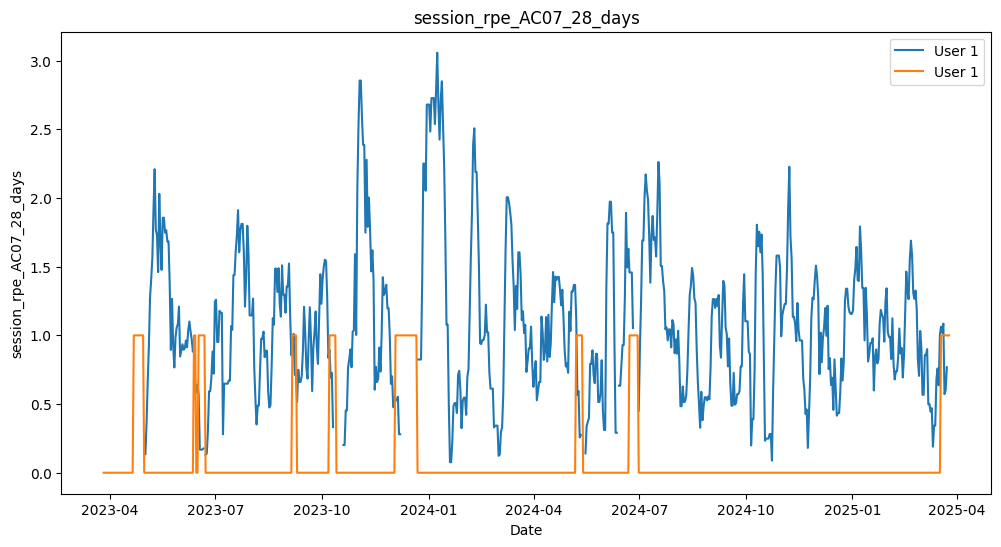

In [8]:
# For exploration purposes, plot when an individual is injured (works for relatively small numbers (<15 ish))
def plot_injury_status(df):
    plt.figure(figsize=(12, 6))
    for user_id in df["user_id"].unique():
        user_data = df[df["user_id"] == user_id]
        plt.plot(user_data["date"], user_data["session_rpe_AC07_28_days"], label=f'User {user_id}')
        plt.plot(user_data["date"], user_data["currently_injured"].astype(int), label=f'User {user_id}')

        break
    
    plt.xlabel("Date")
    plt.ylabel("session_rpe_AC07_28_days")
    plt.title("session_rpe_AC07_28_days")
    plt.legend()
    plt.show()
    return

# Example usage:
plot_injury_status(biased_training_load_en_wellness_data)

Hoe vaak komen blessures vooor?

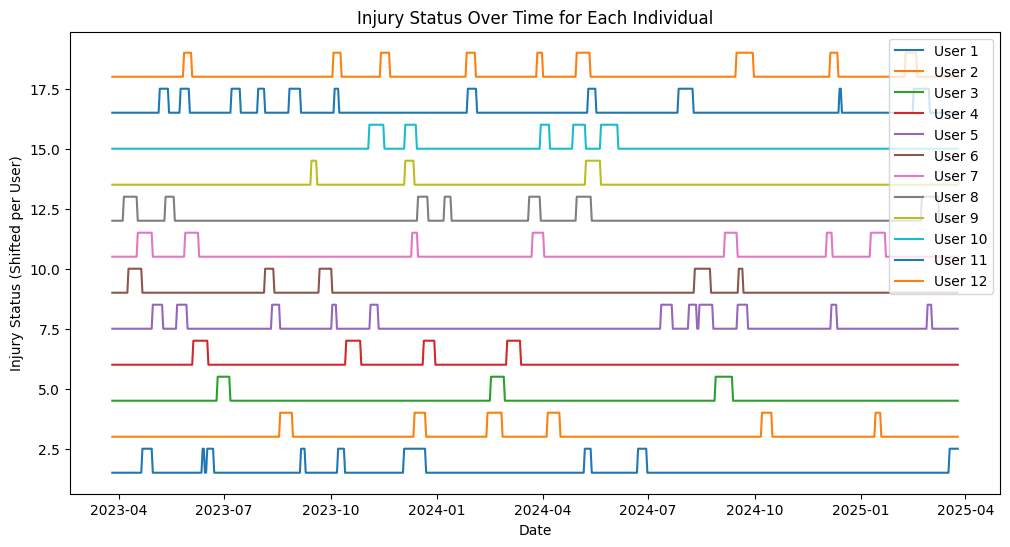

In [9]:
# For exploration purposes, plot when an individual is injured (works for relatively small numbers (<15 ish))
def plot_injury_status(df):
    plt.figure(figsize=(12, 6))
    for user_id in df["user_id"].unique():
        user_data = df[df["user_id"] == user_id]
        plt.plot(user_data["date"], user_data["currently_injured"].astype(int) + user_id * 1.5, label=f'User {user_id}')
    
    plt.xlabel("Date")
    plt.ylabel("Injury Status (Shifted per User)")
    plt.title("Injury Status Over Time for Each Individual")
    plt.legend()
    plt.show()
    return

# Example usage:
plot_injury_status(injury_data)

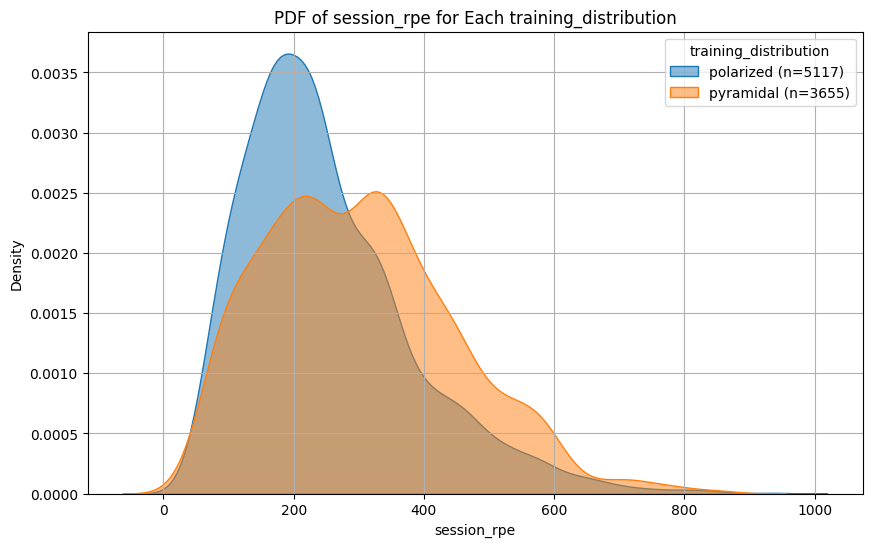

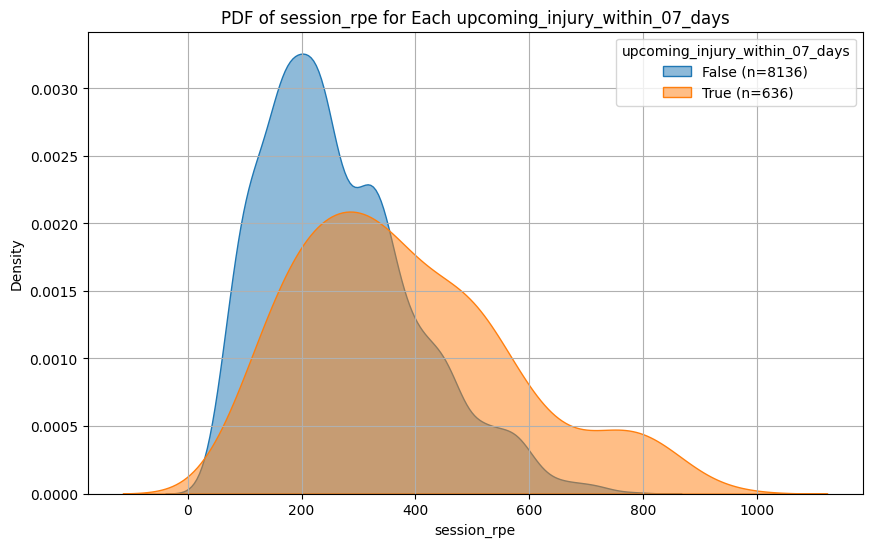

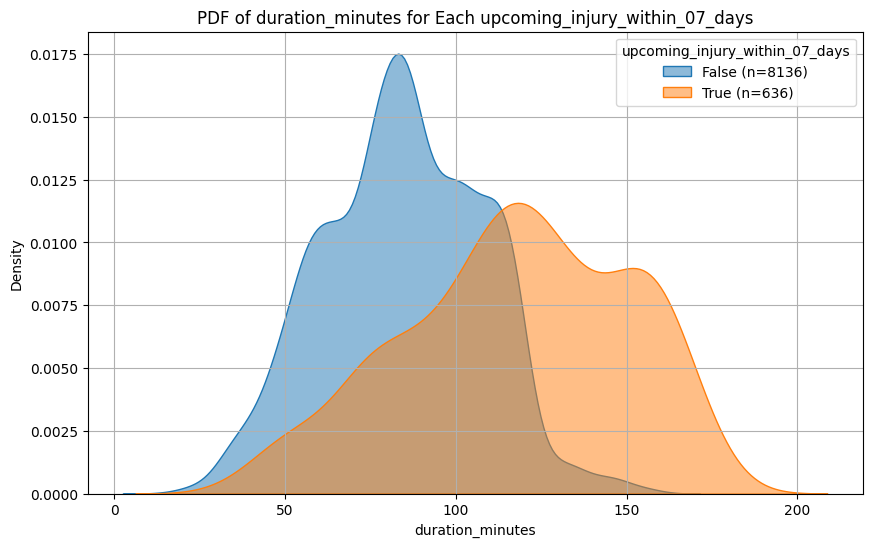

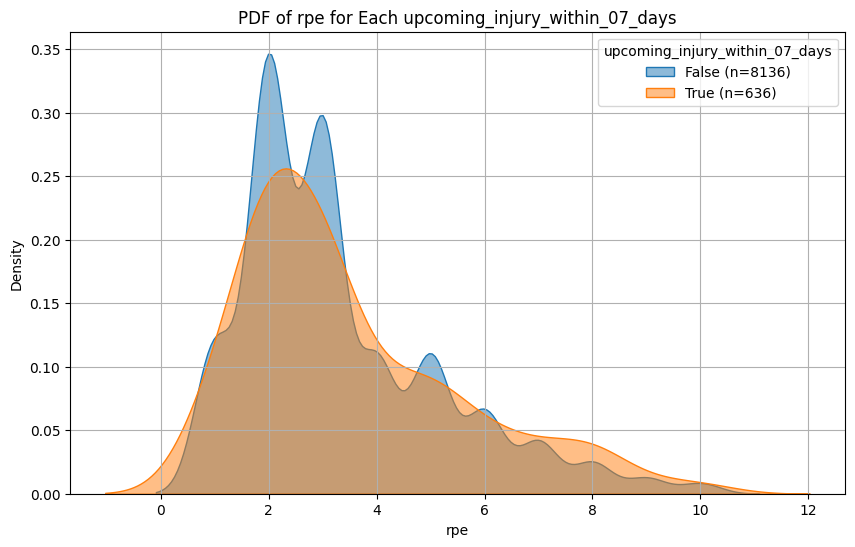

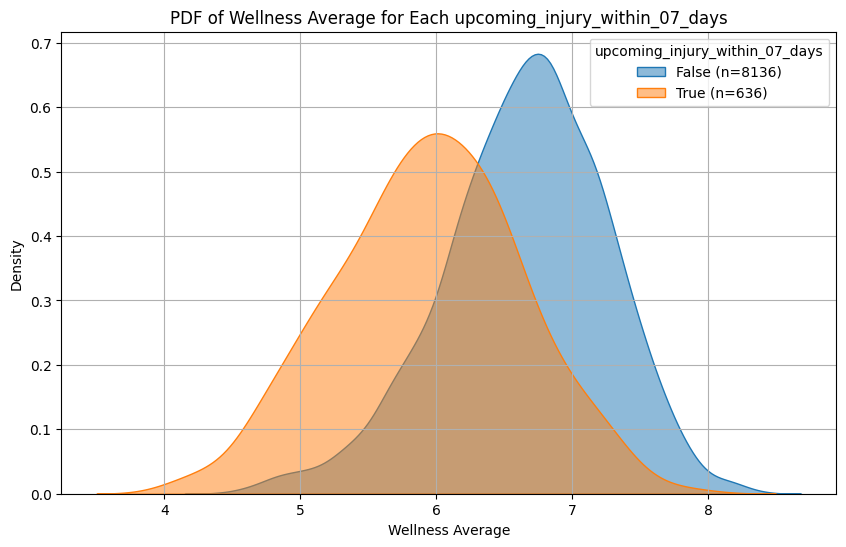

In [10]:
# Plot PDFs of the two training distributions
# Dataframe training_load_data contains a column called sRPE (floats) and training_distribution (strings, 2 unique values). Plot two PDFs in the same plot of sRPE, one for each training_distribution.
def compare_distributions(df, group_col = 'training_distribution', val_col = 'session_rpe'):
     # Create the plot
     plt.figure(figsize=(10, 6))

     # Loop through each unique category in training_distribution
     for category in df[group_col].unique():
          sns.kdeplot(
               data=df[df[group_col] == category], 
               x=val_col, 
               label=f'{category} (n={sum(df[group_col] == category)})', 
               fill=True, 
               alpha=0.5
          )

     # Labels and title
     plt.xlabel(val_col)
     plt.ylabel('Density')
     plt.title(f'PDF of {val_col} for Each {group_col}')
     plt.legend(title=group_col)
     plt.grid(True)

     # Show the plot
     plt.show()

# Example usage
compare_distributions(biased_training_load_en_wellness_data, group_col = 'training_distribution', val_col = 'session_rpe')
compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'session_rpe')
compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'duration_minutes')
compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'rpe')
compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'Wellness Average')



Hoe verschillen de trainingsdistributies?

[1, 2, 3, 4, 5, 8, 10, 11, 12, 6, 7, 9]


<Figure size 1200x800 with 0 Axes>

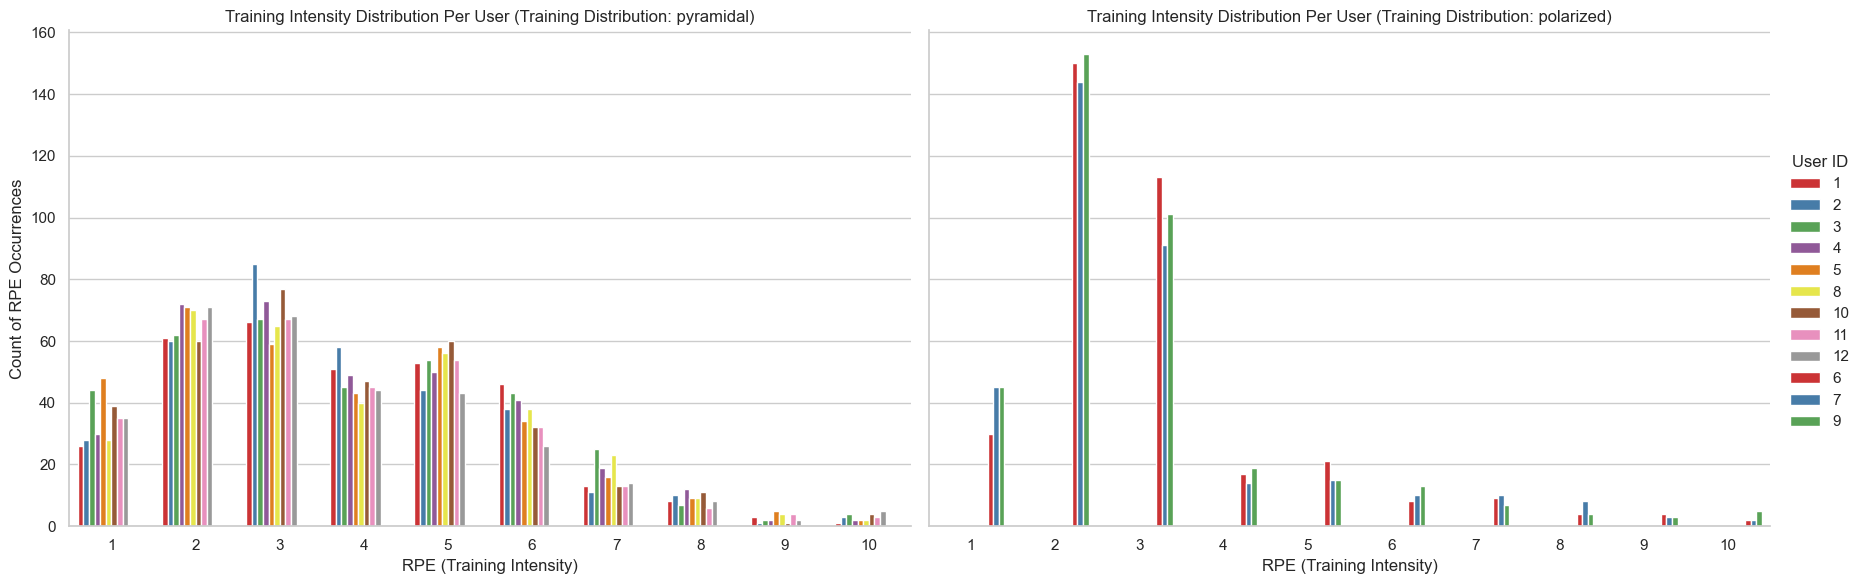

In [11]:
def plot_training_intensity_distribution(training_load_data):
    training_data = training_load_data.loc[training_load_data['rpe'].notnull(), :].copy()
    # training_data = training_data.sort_values(by='training_distribution')
    # Ensure 'rpe' is treated as a categorical variable
    training_data['rpe'] = training_data['rpe'].astype(int)

    # Group by user_id, rpe, and training_distribution to count the occurrences
    user_rpe_distribution = training_data.groupby(['user_id', 'rpe', 'training_distribution']).size().reset_index(name='count')
    
    # Define the desired order of user IDs
    users_method_1 = training_data.loc[training_data['training_distribution']==training_data['training_distribution'].unique()[0],'user_id'].unique().tolist()
    users_method_2 = sorted(set(user_rpe_distribution['user_id']) - set(users_method_1))
    user_order = users_method_1 + users_method_2    
    print(user_order)
    # Convert user_id to categorical with the specified order
    user_rpe_distribution['user_id'] = pd.Categorical(user_rpe_distribution['user_id'], categories=user_order, ordered=True)

    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    
    # Create the plot, splitting by 'training_distribution'
    g = sns.catplot(x="rpe", y="count", hue="user_id", col="training_distribution", data=user_rpe_distribution,
                    kind="bar", height=6, aspect=1.5, palette="Set1")
    
    g.set_axis_labels("RPE (Training Intensity)", "Count of RPE Occurrences")
    g.set_titles("Training Intensity Distribution Per User (Training Distribution: {col_name})")
    
    # Adjust the legend
    g.legend.set_title("User ID")
    
    plt.show()

# Example Usage:
plot_training_intensity_distribution(training_load_data)

C:\Users\rmeer\AppData\Local\Temp\ipykernel_24828\4221974184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['rpe'] = training_data['rpe'].astype(int)
C:\Users\rmeer\AppData\Local\Temp\ipykernel_24828\4221974184.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rpe', y='proportion', data=user_rpe_distribution, ax=axes[i], palette="Set1")
C:\Users\rmeer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a 

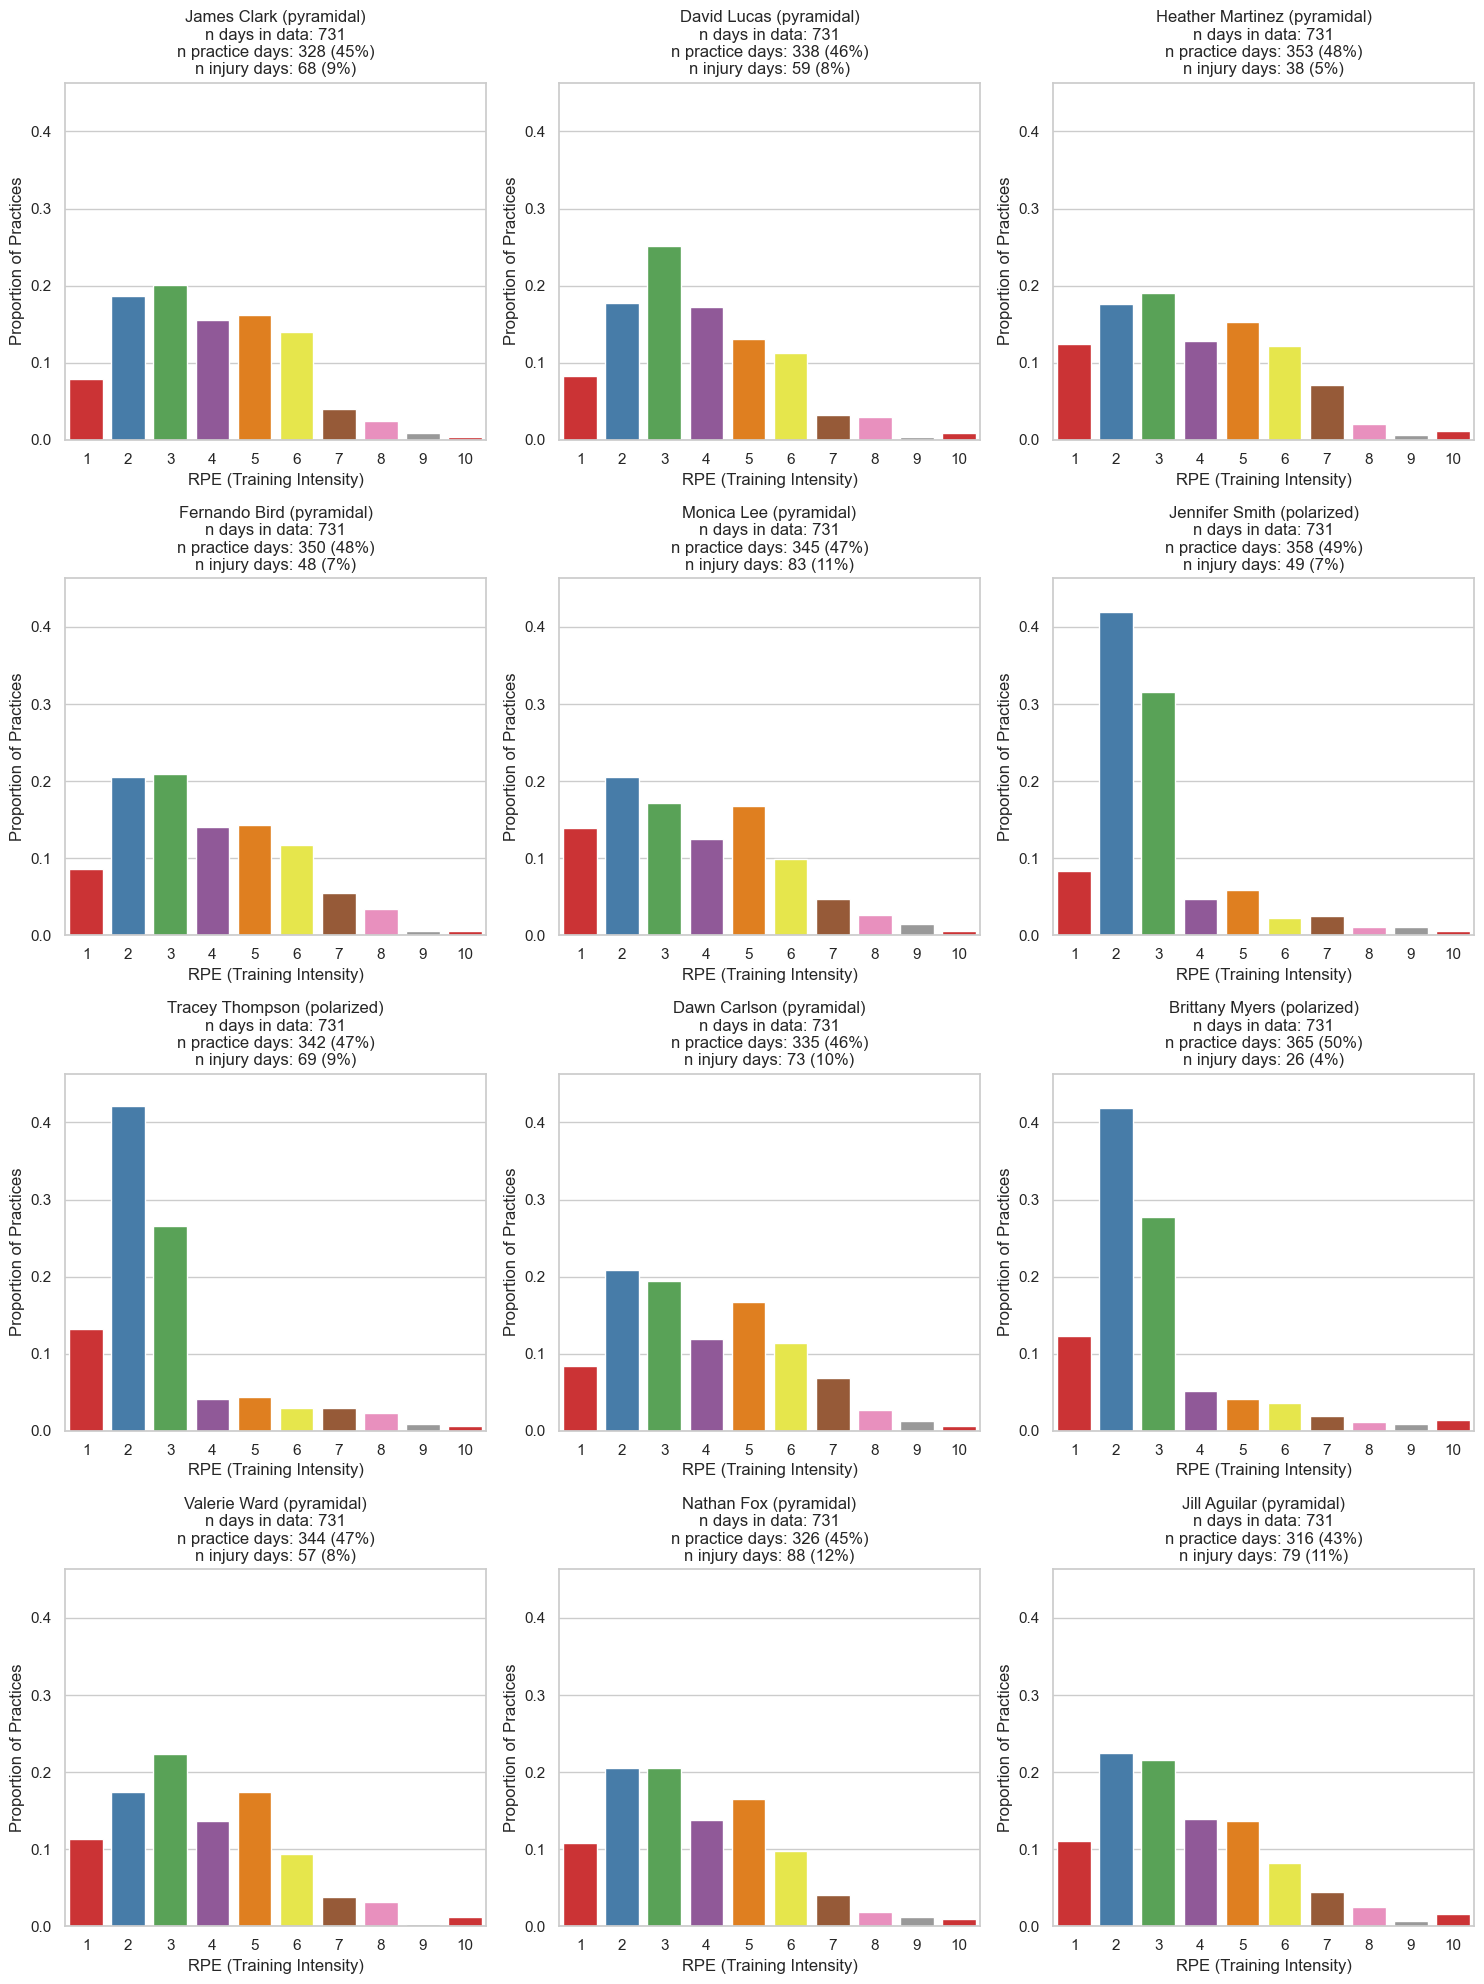

In [12]:
def plot_training_intensity_distribution(training_load_data):
    training_data = training_load_data.loc[training_load_data['rpe'].notnull(), :]
    # Ensure 'rpe' is treated as a categorical variable
    training_data['rpe'] = training_data['rpe'].astype(int)

    # Get unique user IDs
    user_ids = training_data['user_id'].unique()

    # Set up the plot grid: create a subplot for each user
    n_users = len(user_ids)
    n_cols = 3  # Number of columns for the subplots
    n_rows = (n_users // n_cols) + (n_users % n_cols > 0)  # Calculate number of rows required

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes for easier indexing

    # Find the maximum proportion across all users
    max_proportion_all_users = 0
    user_max_proportions = {}

    # First, calculate the max proportion for each user to determine global max
    for user_id in user_ids:
        user_data = training_data[training_data['user_id'] == user_id]
        
        # Group by 'rpe' to count the occurrences of each RPE value for the user
        user_rpe_distribution = user_data.groupby('rpe').size().reset_index(name='count')
        
        # Calculate the total number of practices for this user
        total_practices = user_data.shape[0]
        
        # Normalize the counts to get the proportion of each RPE value
        user_rpe_distribution['proportion'] = user_rpe_distribution['count'] / total_practices
        
        # Find the maximum proportion for this user
        user_max_proportion = user_rpe_distribution['proportion'].max()
        user_max_proportions[user_id] = user_max_proportion
        
        # Update the global maximum proportion
        max_proportion_all_users = max(max_proportion_all_users, user_max_proportion)

    # Set up the plot grid and plot the data
    for i, user_id in enumerate(user_ids):
        user_data = training_data[training_data['user_id'] == user_id]
        user_injury_data = training_load_data[training_load_data['user_id'] == user_id]
        
        # Group by 'rpe' to count the occurrences of each RPE value for the user
        user_rpe_distribution = user_data.groupby('rpe').size().reset_index(name='count')
        
        # Calculate the total number of practices for this user
        total_practices = user_data.shape[0]
        
        # Normalize the counts to get the proportion of each RPE value
        user_rpe_distribution['proportion'] = user_rpe_distribution['count'] / total_practices

        # Plot the relative frequency (proportion) for each RPE value
        sns.barplot(x='rpe', y='proportion', data=user_rpe_distribution, ax=axes[i], palette="Set1")
        
        # Add the user name and training_distribution value to the title
        user_name = user_data['user_name'].iloc[0]
        training_distribution = user_data['training_distribution'].iloc[0]
        axes[i].set_title(f"{user_name} ({training_distribution})\nn days in data: {user_injury_data.shape[0]}\nn practice days: {user_injury_data['rpe'].notnull().sum()} ({user_injury_data['rpe'].notnull().sum() / user_injury_data.shape[0]*100:.0f}%)\nn injury days: {sum(user_injury_data['currently_injured']==True)} ({sum(user_injury_data['currently_injured']==True) / user_injury_data.shape[0]*100:.0f}%)", fontsize=12)
        
        # Set axis labels
        axes[i].set_xlabel("RPE (Training Intensity)")
        axes[i].set_ylabel("Proportion of Practices")
        
        # Set the y-axis limits to the same value across all users, based on the observed max proportion
        axes[i].set_ylim(0, max_proportion_all_users * 1.1)  # Add a small buffer (10%)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example Usage:
plot_training_intensity_distribution(training_load_data)

C:\Users\rmeer\AppData\Local\Temp\ipykernel_24828\3546481078.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury, introduce_bias_n_days_before = introduce_bias_n_days_before, upcoming_injury_col_full = upcoming_injury_col_full, upcoming_injury_col_half = upcoming_injury_col_half, upcoming_injury_col_quarter = upcoming_injury_col_quarter).reset_index(drop=True)


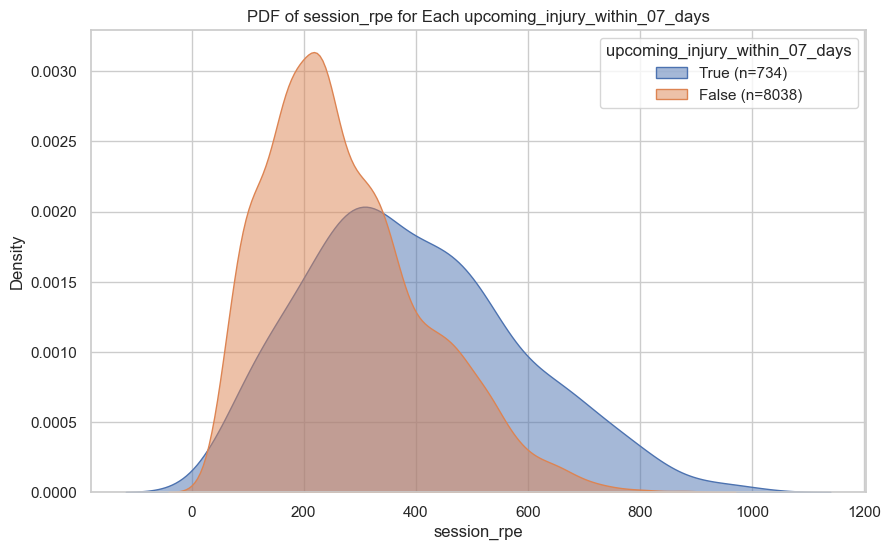

In [20]:
max_pct_bias = 50
introduce_bias_n_days_before = 28
bias_power = 2

wellness_max_pct_bias = 200
wellness_bias_power = 1

# Whether to apply the inactivity reduction
apply_inactivity_reduction = True
# Window for which inactivity is checked
check_n_days_for_inactivity = 7
# Max reduction of training duration
max_inactivity_reduction = 0.5
# Minimum number of practices to be considered as active
min_n_practices_as_active = 3                

# Types of bias
# - Seiler's blackhole
# - No slow build-up
# - Too high volume
# - No recovery

injury_data = generate_fake_injury_data(n_individuals = 12, time_span_years = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3)
injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury, introduce_bias_n_days_before = introduce_bias_n_days_before, upcoming_injury_col_full = upcoming_injury_col_full, upcoming_injury_col_half = upcoming_injury_col_half, upcoming_injury_col_quarter = upcoming_injury_col_quarter).reset_index(drop=True)
biased_training_load_data = generate_fake_training_load_data_from_injury(injury_data, 
    rpe_table_type='randomly_assigned_per_user_id', 
    introduce_bias_n_days_before = introduce_bias_n_days_before, 
    max_pct_bias = max_pct_bias, bias_power = bias_power, 
    apply_inactivity_reduction = apply_inactivity_reduction,
    check_n_days_for_inactivity = check_n_days_for_inactivity,
    max_inactivity_reduction = max_inactivity_reduction,
    min_n_practices_as_active = min_n_practices_as_active)
biased_training_load_en_wellness_data = generate_fake_wellness_data_from_injury(biased_training_load_data, introduce_bias_n_days_before = introduce_bias_n_days_before, max_pct_bias = wellness_max_pct_bias, bias_power = wellness_bias_power)
biased_training_load_en_wellness_data = feature_construction(biased_training_load_en_wellness_data)

# compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'Wellness Average')
compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'session_rpe')

C:\Users\rmeer\AppData\Local\Temp\ipykernel_24828\1495056572.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury, introduce_bias_n_days_before = introduce_bias_n_days_before, upcoming_injury_col_full = upcoming_injury_col_full, upcoming_injury_col_half = upcoming_injury_col_half, upcoming_injury_col_quarter = upcoming_injury_col_quarter).reset_index(drop=True)


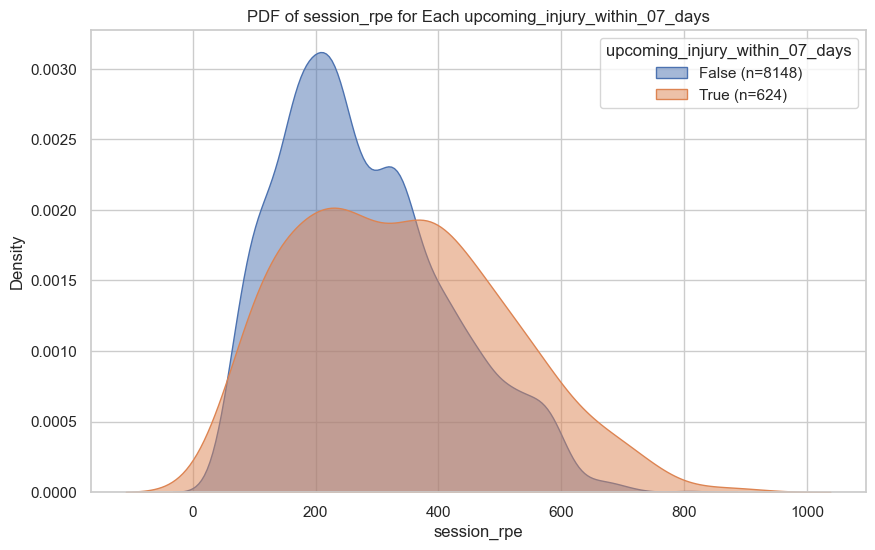

In [21]:
max_pct_bias = 25
introduce_bias_n_days_before = 28
bias_power = 2

wellness_max_pct_bias = 100
wellness_bias_power = 1

# Whether to apply the inactivity reduction
apply_inactivity_reduction = True
# Window for which inactivity is checked
check_n_days_for_inactivity = 7
# Max reduction of training duration
max_inactivity_reduction = 0.5
# Minimum number of practices to be considered as active
min_n_practices_as_active = 3                

# Types of bias
# - Seiler's blackhole
# - No slow build-up
# - Too high volume
# - No recovery

injury_data = generate_fake_injury_data(n_individuals = 12, time_span_years = 2, injury_onset_incidence = 0.01, injury_duration_mean = 10, injury_duration_std = 3)
injury_data = injury_data.groupby('user_id', group_keys=False).apply(add_days_until_next_injury, introduce_bias_n_days_before = introduce_bias_n_days_before, upcoming_injury_col_full = upcoming_injury_col_full, upcoming_injury_col_half = upcoming_injury_col_half, upcoming_injury_col_quarter = upcoming_injury_col_quarter).reset_index(drop=True)
biased_training_load_data = generate_fake_training_load_data_from_injury(injury_data, 
    rpe_table_type='randomly_assigned_per_user_id', 
    introduce_bias_n_days_before = introduce_bias_n_days_before, 
    max_pct_bias = max_pct_bias, bias_power = bias_power, 
    apply_inactivity_reduction = apply_inactivity_reduction,
    check_n_days_for_inactivity = check_n_days_for_inactivity,
    max_inactivity_reduction = max_inactivity_reduction,
    min_n_practices_as_active = min_n_practices_as_active)
biased_training_load_en_wellness_data = generate_fake_wellness_data_from_injury(biased_training_load_data, introduce_bias_n_days_before = introduce_bias_n_days_before, max_pct_bias = wellness_max_pct_bias, bias_power = wellness_bias_power)
biased_training_load_en_wellness_data = feature_construction(biased_training_load_en_wellness_data)

# compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'Wellness Average')
compare_distributions(biased_training_load_en_wellness_data, group_col = upcoming_injury_col_quarter, val_col = 'session_rpe')